# Train a Regression Model

In this notebook we will train a Linear Regression Model on the Green Taxi Dataset. We will only use one month for the training. And keep only a small number of features. 

We want the model to predict the duration of a trip. This can be useful for the taxi drivers to plan their trips, for the customers to know how long a trip will take but also for the taxi companies to plan their fleet. The first two predictions would need real time predictions because the duration of a trip is not known in advance. The last one could be done in batch mode, as it is more a analytical task that doesn't need to be done in real time.

Additionally, we will use MLFlow to track the model training and log the model artifacts.

In [20]:
import os
from dotenv import load_dotenv

import pandas as pd

import mlflow
from mlflow.tracking.client import MlflowClient

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#import randomforest regressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [21]:
year = 2021
month = 9
color = "green"

In [22]:
# Download the data
if not os.path.exists(f"./data/{color}_tripdata_{year}-{month:02d}.parquet"):
    os.system(f"wget -P ./data https://d37ci6vzurychx.cloudfront.net/trip-data/{color}_tripdata_{year}-{month:02d}.parquet")

--2023-07-19 14:59:04--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-09.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 108.138.225.114, 108.138.225.93, 108.138.225.126, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|108.138.225.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1883216 (1,8M) [binary/octet-stream]
Saving to: ‘./data/green_tripdata_2021-09.parquet’

     0K .......... .......... .......... .......... ..........  2%  580K 3s
    50K .......... .......... .......... .......... ..........  5%  999K 2s
   100K .......... .......... .......... .......... ..........  8% 35,8M 2s
   150K .......... .......... .......... .......... .......... 10% 3,51M 1s
   200K .......... .......... .......... .......... .......... 13% 1,41M 1s
   250K .......... .......... .......... .......... .......... 16%  132M 1s
   300K .......... .......... .......... .......... ....

In [23]:
# Load the data

df = pd.read_parquet(f"./data/{color}_tripdata_{year}-{month:02d}.parquet")

In [24]:
df.shape

(95709, 20)

Now we will set up the connection to MLFlow. For that we have to create a `.env` file with the URI to the MLFlow Server in gcp (this will be `http://<external-ip>:5000`). You can simply run:

```bash
echo "MLFLOW_TRACKING_URI=http://<external-ip>:5000" > .env
```

We also will create an experiment to track the model and the metrics.

In [25]:
load_dotenv()

MLFLOW_TRACKING_URI=os.getenv("MLFLOW_TRACKING_URI")

In [26]:
# Set up the connection to MLflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
# Setup the MLflow experiment 
mlflow.set_experiment("green-taxi-monitoring")

<Experiment: artifact_location='gs://mlflow-production/mlflow/4', creation_time=1689756962793, experiment_id='4', last_update_time=1689756962793, lifecycle_stage='active', name='green-taxi-monitoring', tags={}>

If everything went well, you should be able to see the experiment now in the MLFlow UI at `http://<external-ip>:5000`.

Let's start now with looking at the data a bit:

In [27]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-09-01 00:30:44,2021-09-01 00:36:58,N,1.0,74,41,1.0,1.22,6.5,0.5,0.5,1.95,0.0,None,0.3,9.75,1.0,1.0,0.00
1,2,2021-09-01 00:39:00,2021-09-01 00:54:06,N,1.0,41,263,1.0,3.14,13.0,0.5,0.5,2.56,0.0,None,0.3,19.61,1.0,1.0,2.75
2,2,2021-09-01 00:57:51,2021-09-01 01:19:58,N,1.0,93,141,1.0,10.79,31.0,0.5,0.5,5.50,0.0,None,0.3,40.55,1.0,1.0,2.75
3,2,2021-09-01 00:00:11,2021-09-01 00:01:39,N,1.0,74,74,1.0,0.02,3.0,0.5,0.5,0.00,0.0,None,0.3,4.30,2.0,1.0,0.00
4,2,2021-09-01 00:29:26,2021-09-01 01:04:03,N,1.0,255,35,1.0,6.57,26.5,0.5,0.5,0.00,0.0,None,0.3,27.80,2.0,1.0,0.00


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95709 entries, 0 to 95708
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               95709 non-null  int64         
 1   lpep_pickup_datetime   95709 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  95709 non-null  datetime64[ns]
 3   store_and_fwd_flag     61284 non-null  object        
 4   RatecodeID             61284 non-null  float64       
 5   PULocationID           95709 non-null  int64         
 6   DOLocationID           95709 non-null  int64         
 7   passenger_count        61284 non-null  float64       
 8   trip_distance          95709 non-null  float64       
 9   fare_amount            95709 non-null  float64       
 10  extra                  95709 non-null  float64       
 11  mta_tax                95709 non-null  float64       
 12  tip_amount             95709 non-null  float64       
 13  t

In [29]:
# Look for missing values
df.isnull().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag       34425
RatecodeID               34425
PULocationID                 0
DOLocationID                 0
passenger_count          34425
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                95709
improvement_surcharge        0
total_amount                 0
payment_type             34425
trip_type                34425
congestion_surcharge     34425
dtype: int64

Nearly all features seem to be in the correct type and we have only missings in features that we will not use for the model training. For predicting the duration of a trip, we will use the following features:

- `PULocationID`: The pickup location ID
- `DOLocationID`: The dropoff location ID
- `trip_distance`: The distance of the trip in miles
- `fare_amount`: The fare amount in USD
- `total_amount`: The total amount in USD
- `passenger_count`: The number of passengers

But first we have to calculate the duration of the trip in minutes because it is our target. For that we will use the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns. We will also remove all trips that have a duration of 0 and that are longer than 1 hours to remove outliers.

In [30]:
features = ["PULocationID", "DOLocationID", "trip_distance", "passenger_count", "fare_amount", "total_amount"]
target = 'duration'

In [31]:
# calculate the trip duration in minutes and drop trips that are less than 1 minute and more than 2 hours
def calculate_trip_duration_in_minutes(df):
    df["duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]).dt.total_seconds() / 60
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 8)]
    df = df[features + [target]]
    return df
    

In [32]:
df_processed = calculate_trip_duration_in_minutes(df)

In [33]:
df_processed.head()

,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount,total_amount,duration
0,74,41,1.22,1.0,6.5,9.75,6.233333
1,41,263,3.14,1.0,13.0,19.61,15.100000
2,93,141,10.79,1.0,31.0,40.55,22.116667
3,74,74,0.02,1.0,3.0,4.30,1.466667
4,255,35,6.57,1.0,26.5,27.80,34.616667


In [34]:
df_processed.duration.describe()

count    56437.000000
mean        16.277459
std         11.439164
min          1.000000
25%          8.183333
50%         13.133333
75%         21.016667
max         60.000000
Name: duration, dtype: float64

<Axes: >

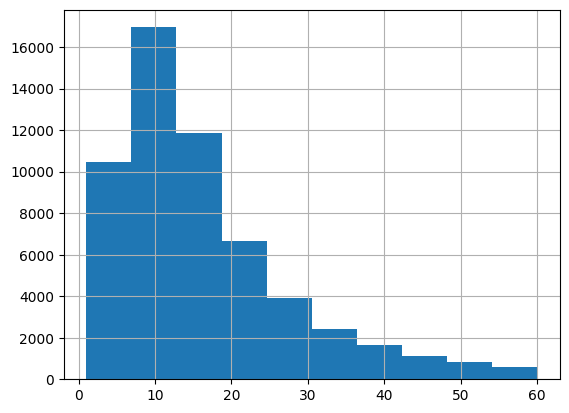

In [35]:
df_processed.duration.hist()

Now that we have the dataframe that we want to train our model on. We need to split it into a train and test set. We will use 80% of the data for training and 20% for testing.

In [36]:
y=df_processed["duration"]
X=df_processed.drop(columns=["duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

And now we can train the model and track the experiment with MLFlow. We will set tags to the experiment to make it easier to find it later.

- `model`: `linear-regression`
- `dataset`: `yellow-taxi`
- `developer`: `your-name`
- `train_size`: The size of the train set
- `test_size`: The size of the test set
- `features`: The features that we used for training
- `target`: The target that we want to predict
- `year`: The year of the data
- `month`: The month of the data

We could also log the model parameters but Linear Regression doesn't have any.

And finally we will log the metrics:

- `rmse`: The root mean squared error

We will also log the model artifacts. For that we will need to set the `service account json` that we downloaded earlier as the environment variable `GOOGLE_APPLICATION_CREDENTIALS`. 

In [37]:
SA_KEY= os.getenv("SA_KEY")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SA_KEY

In [38]:
with mlflow.start_run():
    
    tags = {
        "model": "linear regression",
        "developer": "Victor Matekole",
        "dataset": f"{color}-taxi",
        "year": year,
        "month": month,
        "features": features,
        "target": target
    }
    mlflow.set_tags(tags)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.sklearn.log_model(lr, "model")
    run_id = mlflow.active_run().info.run_id

    model_uri = f"runs:/{run_id}/model"
    model_name = "green-taxi-ride-duration"
    mlflow.register_model(model_uri=model_uri, name=model_name)

    model_version = 1
    new_stage = "Production"
    client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

Registered model 'green-taxi-ride-duration' already exists. Creating a new version of this model...
2023/07/19 14:59:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: green-taxi-ride-duration, version 4
Created version '4' of model 'green-taxi-ride-duration'.


You should now see your run in the MLFlow UI. Under the created experiment. You can also see the logged tags, the metric and the saved model.

![mlflow-ui](./images/mlflow-run.png)

And you can see what you need to do to load the model in an API or script in the UI as long as the application has access to MLFlow.
